# Problem Statement

Ebuss in an e-commerce company which has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, we are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

In [18]:
import nltk
nltk.download('punkt')
from nltk import FreqDist
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\deepak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

In [20]:
from wordcloud import WordCloud
import swifter
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pickle

In [21]:
import spacy
#!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [22]:
from sklearn.metrics.pairwise import pairwise_distances

### Data sourcing and understanding

In [23]:
dfreviews=pd.read_csv('data/sample30.csv')
dfreviews.head()

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                          categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Mo...   
1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
2  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
3  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
4  Personal Care,Medicine Cabinet,Lubricant/Sperm...   

                         manufacturer  \
0  Universal Music Group / Cash Money   
1                            Lundberg   
2                            Lundberg   
3                                 K-Y   
4                                 K-Y   

                                         name              reviews_date  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd)  2012-11-30T06:21:45.000Z   
1  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
2  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
3            K-Y Love Sensuality Pleasure Gel  2016-01-06T00:00:00.000Z   
4            K-Y Love Sensuality Pleasure Gel  2016-12-21T00:00:00.000Z   

  reviews_didPurchase reviews_doRecommend  reviews_rating  \
0                 NaN                 NaN               5   
1                True                 NaN               5   
2                True                 NaN               5   
3               False               False               1   
4               False               False               1   

                                        reviews_text reviews_title  \
0  i love this album. it's very good. more to the...  Just Awesome   
1  Good flavor. This review was collected as part...          Good   
2                                       Good flavor.          Good   
3  I read through the reviews on here before look...  Disappointed   
4  My husband bought this gel for us. The gel cau...    Irritation   

  reviews_userCity reviews_userProvince reviews_username user_sentiment  
0      Los Angeles                  NaN           joshua       Positive  
1              NaN                  NaN        dorothy w       Positive  
2              NaN                  NaN        dorothy w       Positive  
3              NaN                  NaN          rebecca       Negative  
4              NaN                  NaN        walker557       Negative

In [24]:
dfreviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [25]:
dfreviews.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [26]:
dfreviews.describe()

reviews_rating
count    30000.000000
mean         4.483133
std          0.988441
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000

### Exploratory Data Analysis

In [27]:
dfreviews.brand.value_counts()

Clorox                   10585
Warner Home Video         3325
Disney                    1200
L'oreal Paris             1186
FOX                        887
                         ...  
Pacific Natural Foods        1
Noosa                        1
Southern Enterprises         1
SLOAN VALVE COMPANY          1
Universal Music              1
Name: brand, Length: 214, dtype: int64

In [28]:
dfreviews.manufacturer.value_counts()

Clorox                                8546
Test                                  3325
AmazonUs/CLOO7                        2039
L'oreal Paris                         1232
Walt Disney                           1143
                                      ... 
Pacific Foods of Oregon, Inc.            1
Unfi                                     1
Herr's                                   1
Southern Enterprises                     1
Universal Music Group / Cash Money       1
Name: manufacturer, Length: 227, dtype: int64

In [29]:
dfreviews.name.value_counts()

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                         8545
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                   3325
Clorox Disinfecting Bathroom Cleaner                                              2039
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    1186
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)               1143
                                                                                  ... 
5302050 15/16 FCT/HOSE ADAPTOR                                                       1
Clorox Ultimate Care Premium Bleach                                                  1
Pocket Watch Wall Clock Distressed Black - Yosemite Home Decor174                    1
Stonyfield Yobaby Peach & Pear Yogurt 4oz 6 Ct                                       1
Pink Friday: Roman Reloaded Re-Up (w/dvd)                                            1
Name: name, Length: 271, dtype: int64

<AxesSubplot:xlabel='reviews_didPurchase', ylabel='count'>

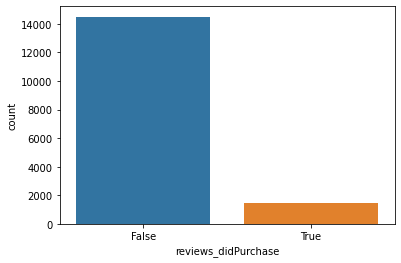

In [30]:
sns.countplot(data=dfreviews,x='reviews_didPurchase')

<AxesSubplot:xlabel='reviews_doRecommend', ylabel='count'>

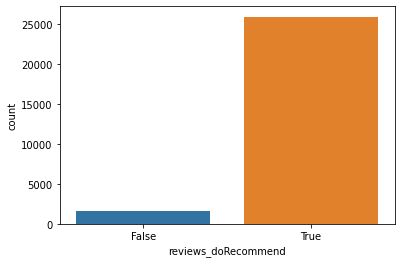

In [31]:
sns.countplot(data=dfreviews,x='reviews_doRecommend')

<AxesSubplot:xlabel='reviews_rating', ylabel='count'>

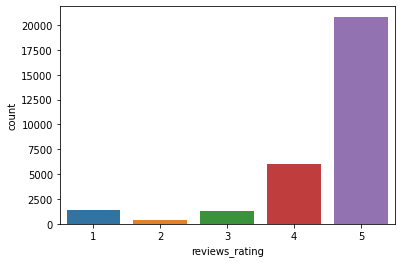

In [32]:
sns.countplot(data=dfreviews,x='reviews_rating')

In [33]:
dfreviews.reviews_title.value_counts()

Great Product                       384
Great movie                         361
Clorox Wipes                        278
Great                               221
Great product                       205
                                   ... 
Keeping them healthy!                 1
Fighting Power                        1
great all together                    1
Great Product and Easy to Use...      1
Conditioned into healthy              1
Name: reviews_title, Length: 18535, dtype: int64

In [34]:
dfreviews.reviews_username.value_counts()

mike                 41
byamazon customer    41
chris                32
lisa                 16
sandy                15
                     ..
nurse32               1
lisa62                1
bigal515              1
mom271                1
kcoopxoxo             1
Name: reviews_username, Length: 24914, dtype: int64

In [35]:
dfreviews.user_sentiment.unique()

array(['Positive', 'Negative', nan], dtype=object)

<AxesSubplot:xlabel='user_sentiment', ylabel='count'>

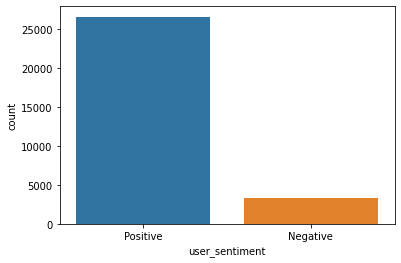

In [36]:
sns.countplot(data=dfreviews,x='user_sentiment')

<AxesSubplot:xlabel='reviews_rating', ylabel='percentage'>

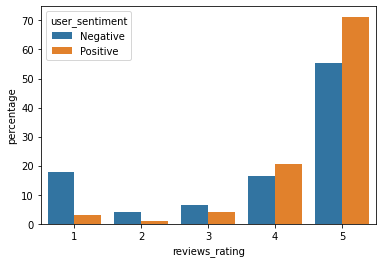

In [37]:
# Ratings distribution for each user sentiment
dfreviews_per_sent=((dfreviews.groupby(['user_sentiment','reviews_rating'])['id'].count()/dfreviews.groupby(['user_sentiment'])['reviews_rating'].count())*100).rename('percentage').reset_index()
sns.barplot(data=dfreviews_per_sent,x='reviews_rating',y='percentage',hue='user_sentiment')

In [38]:
# review text length
dfreviews.reviews_text.str.len().describe()

count    30000.000000
mean       183.056967
std        186.054147
min          2.000000
25%         83.000000
50%        131.000000
75%        217.000000
max       5865.000000
Name: reviews_text, dtype: float64

<AxesSubplot:xlabel='reviews_text', ylabel='Density'>

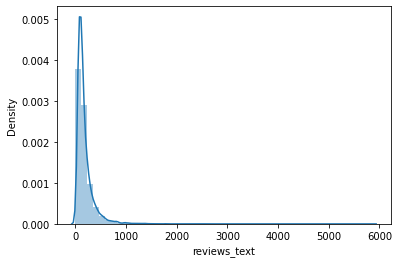

In [39]:
# review text length distribution
sns.distplot(dfreviews.reviews_text.str.len())

### Data Cleaning

In [40]:
# Map the user sentiment to a numerical value
dfreviews['user_sentiment']=dfreviews['user_sentiment'].map({'Positive':1,'Negative':0})
dfreviews.user_sentiment.unique()

array([ 1.,  0., nan])

In [41]:
# Combine the review title with the text
dfreviews['reviews_title_plus_text']=dfreviews['reviews_title'].fillna('')+'. '+dfreviews['reviews_text']

In [42]:
# Use columns which are relevant for sentiment analysis
dfSentiment=dfreviews[['id','name','reviews_title_plus_text','user_sentiment']]

In [43]:
# Remove rows where the user sentiment is not available
dfSentiment=dfSentiment[~dfSentiment.user_sentiment.isnull()].reset_index(drop=True)
dfSentiment.shape

(29999, 4)

In [44]:
dfSentiment.head()

id                                        name  \
0  AV13O1A8GV-KLJ3akUyj   Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
2  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
3  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   
4  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   

                             reviews_title_plus_text  user_sentiment  
0  Just Awesome. i love this album. it's very goo...             1.0  
1  Good. Good flavor. This review was collected a...             1.0  
2                                 Good. Good flavor.             1.0  
3  Disappointed. I read through the reviews on he...             0.0  
4  Irritation. My husband bought this gel for us....             0.0

### Text Processing

In [45]:
# Function to clean the text and remove all the unnecessary elements.
def pre_process(text):
    text=text.lower() # text to lower-case
    text=text.strip() # remove leading and trailing spaces
    text=re.sub('[^\w\s]','',text) # remove punctutations
    return text

In [46]:
# Function to lemmatize the text
def apply_lemma(pre_processed_text):
    t=[]
    doc=nlp(pre_processed_text)
    for token in doc:
        if token.is_stop==False:
            #print(token.lemma_)
            t.append(token.lemma_)
    processed_text=' '.join(t)
    return processed_text

In [47]:
# create a column which has cleaned and lemmatized review text 
dfSentiment['reviews_processed']=dfSentiment.reviews_title_plus_text.swifter.apply(pre_process)
dfSentiment['reviews_processed']=dfSentiment.reviews_processed.swifter.apply(apply_lemma)

Pandas Apply:   0%|          | 0/29999 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/29999 [00:00<?, ?it/s]

In [48]:
dfSentiment.head()

id                                        name  \
0  AV13O1A8GV-KLJ3akUyj   Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
2  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
3  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   
4  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   

                             reviews_title_plus_text  user_sentiment  \
0  Just Awesome. i love this album. it's very goo...             1.0   
1  Good. Good flavor. This review was collected a...             1.0   
2                                 Good. Good flavor.             1.0   
3  Disappointed. I read through the reviews on he...             0.0   
4  Irritation. My husband bought this gel for us....             0.0   

                                   reviews_processed  
0  awesome love album good hip hop current pop so...  
1          good good flavor review collect promotion  
2                                   good good flavor  
3  disappointed read review look buy couple lubri...  
4  irritation husband buy gel gel cause irritatio...

In [49]:
with open('data/dfSentiment.pk', 'wb') as fin:
    pickle.dump(dfSentiment, fin)

In [50]:
# Check frequent words in Negative ad Positive reviews
text_pos=str(dfSentiment[dfSentiment.user_sentiment==1]['reviews_processed'])
text_neg=str(dfSentiment[dfSentiment.user_sentiment==0]['reviews_processed'])

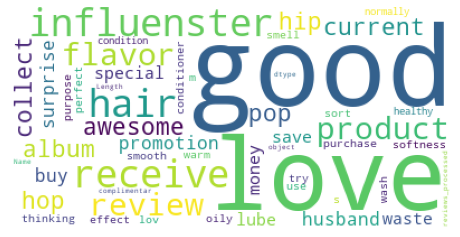

In [51]:
wordcloud = WordCloud(background_color ='white').generate(text_pos)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

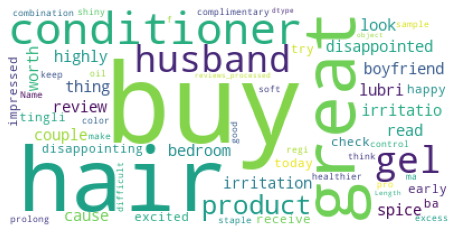

In [52]:
wordcloud = WordCloud(background_color ='white').generate(text_neg)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [53]:
# Find top 30 biagrams with positive sentiments
bigrams=[]
for s in dfSentiment[dfSentiment.user_sentiment==1]['reviews_processed']:
    bigrams.extend(nltk.bigrams(nltk.word_tokenize(s)))
most_common_bigrams=nltk.FreqDist(bigrams).most_common(30)
print(most_common_bigrams)

[(('review', 'collect'), 7942), (('collect', 'promotion'), 7942), (('clorox', 'wipe'), 2583), (('great', 'product'), 1905), (('great', 'movie'), 1684), (('easy', 'use'), 1541), (('love', 'clorox'), 1355), (('love', 'product'), 1173), (('good', 'movie'), 1035), (('smell', 'great'), 841), (('movie', 'great'), 832), (('love', 'love'), 815), (('disinfecting', 'wipe'), 772), (('work', 'great'), 707), (('love', 'wipe'), 682), (('product', 'love'), 668), (('love', 'movie'), 627), (('product', 'use'), 577), (('movie', 'good'), 574), (('product', 'great'), 546), (('godzilla', 'movie'), 543), (('wipe', 'love'), 538), (('good', 'product'), 535), (('use', 'clorox'), 532), (('receive', 'product'), 528), (('clorox', 'disinfecting'), 528), (('hair', 'feel'), 525), (('lip', 'shimmer'), 515), (('wipe', 'clean'), 452), (('clorox', 'product'), 446)]


In [54]:
# Find top 30 biagrams with negative sentiments
bigrams=[]
for s in dfSentiment[dfSentiment.user_sentiment==0]['reviews_processed']:
    bigrams.extend(nltk.bigrams(nltk.word_tokenize(s)))
most_common_bigrams=nltk.FreqDist(bigrams).most_common(30)
print(most_common_bigrams)

[(('review', 'collect'), 801), (('collect', 'promotion'), 801), (('clorox', 'wipe'), 260), (('old', 'formula'), 174), (('new', 'formula'), 163), (('bring', 'old'), 117), (('great', 'product'), 111), (('resident', 'evil'), 103), (('use', 'clorox'), 98), (('great', 'movie'), 68), (('use', 'product'), 67), (('product', 'use'), 67), (('lip', 'shimmer'), 65), (('use', 'wipe'), 63), (('love', 'clorox'), 60), (('exxtra', 'gel'), 59), (('new', 'product'), 58), (('love', 'product'), 56), (('wipe', 'use'), 54), (('not', 'like'), 52), (('good', 'product'), 48), (('disinfecting', 'wipe'), 48), (('new', 'gel'), 47), (('feel', 'like'), 45), (('bring', 'cocoa'), 45), (('will', 'not'), 44), (('change', 'formula'), 44), (('good', 'movie'), 44), (('clorox', 'product'), 43), (('love', 'movie'), 42)]


In [55]:
# Find top 30 biagrams with positive sentiments
trigrams=[]
for s in dfSentiment[dfSentiment.user_sentiment==1]['reviews_processed']:
    trigrams.extend(nltk.trigrams(nltk.word_tokenize(s)))
most_common_trigrams=nltk.FreqDist(trigrams).most_common(30)
print(most_common_trigrams)

[(('review', 'collect', 'promotion'), 7942), (('love', 'clorox', 'wipe'), 663), (('clorox', 'disinfecting', 'wipe'), 524), (('clean', 'review', 'collect'), 443), (('product', 'review', 'collect'), 402), (('use', 'clorox', 'wipe'), 290), (('great', 'product', 'love'), 287), (('use', 'review', 'collect'), 272), (('great', 'movie', 'great'), 261), (('opinion', 'review', 'collect'), 253), (('clorox', 'wipe', 'love'), 251), (('movie', 'great', 'movie'), 243), (('wipe', 'easy', 'use'), 236), (('receive', 'product', 'free'), 227), (('product', 'easy', 'use'), 217), (('love', 'love', 'love'), 216), (('great', 'review', 'collect'), 192), (('love', 'clorox', 'product'), 188), (('testing', 'purpose', 'opinion'), 182), (('great', 'product', 'great'), 181), (('wipe', 'review', 'collect'), 178), (('clorox', 'wipe', 'great'), 174), (('love', 'review', 'collect'), 171), (('clorox', 'wipe', 'easy'), 169), (('love', 'clorox', 'disinfecting'), 168), (('bring', 'old', 'formula'), 167), (('disinfect', 'rev

In [56]:
# Find top 30 biagrams with negative sentiments
trigrams=[]
for s in dfSentiment[dfSentiment.user_sentiment==0]['reviews_processed']:
    trigrams.extend(nltk.trigrams(nltk.word_tokenize(s)))
most_common_trigrams=nltk.FreqDist(trigrams).most_common(30)
print(most_common_trigrams)

[(('review', 'collect', 'promotion'), 801), (('bring', 'old', 'formula'), 74), (('use', 'clorox', 'wipe'), 65), (('use', 'review', 'collect'), 33), (('love', 'clorox', 'wipe'), 33), (('clorox', 'disinfecting', 'wipe'), 33), (('resident', 'evil', 'movie'), 32), (('cocoa', 'lip', 'shimmer'), 29), (('cold', 'flu', 'season'), 27), (('like', 'like', 'like'), 26), (('season', 'review', 'collect'), 25), (('product', 'review', 'collect'), 24), (('house', 'review', 'collect'), 24), (('great', 'product', 'use'), 21), (('clean', 'review', 'collect'), 19), (('nexxus', 'exxtra', 'gel'), 19), (('clorox', 'wipe', 'clean'), 18), (('wipe', 'review', 'collect'), 18), (('clorox', 'wipe', 'use'), 18), (('germ', 'review', 'collect'), 18), (('new', 'formula', 'horrible'), 17), (('flu', 'season', 'review'), 17), (('old', 'formula', 'new'), 17), (('home', 'review', 'collect'), 16), (('disinfect', 'review', 'collect'), 15), (('bathroom', 'review', 'collect'), 15), (('year', 'new', 'formula'), 15), (('clorox', 

### Feature extraction

In [57]:
X=dfSentiment['reviews_processed'].values
y=dfSentiment['user_sentiment'].values

In [58]:
#Write your code here to initialise the TfidfVectorizer 
tfidf=TfidfVectorizer(max_features=2000,ngram_range=(1,2),max_df=0.95,min_df=2)

In [59]:
X_tfidf = tfidf.fit_transform(X).toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
feature_names = tfidf.get_feature_names()
len(feature_names)

2000

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,y,random_state=100,train_size=0.8)

In [62]:
counter = Counter(y_train)
print(counter)

Counter({1.0: 21287, 0.0: 2712})


In [63]:
# Class imbalance can be seen as the positve sentiments are a lot more than negative sentiments
# Balance the class using smote
sm=SMOTE()
X_train, y_train=sm.fit_resample(X_train, y_train)

In [64]:
counter = Counter(y_train)
print(counter)

Counter({1.0: 21287, 0.0: 21287})


### Model Training

In [65]:
def print_metrics(y, y_pred):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1score = f1_score(y, y_pred)
    #tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    #specificity = float(tn)/(tn+fp)
    print(f"Accuracy is : {accuracy*100:.1f}%")
    print(f"Precision is : {precision*100:.1f}%")
    print(f"Recall is : {recall*100:.1f}%")
    print(f"F1 Score is : {f1score*100:.1f}%")
    #print(f"Specificity is : {specificity*100:.1f}%")

def evaluate_model(clf, X_train, y_train, X_test, y_test):
    y_train_pred=clf.predict(X_train)
    print("#### Metrics on Train Data ####")
    print_metrics(y_train,y_train_pred)
    plot_confusion_matrix(clf, X_train, y_train)
    plt.show()

    y_test_pred=clf.predict(X_test)
    print('\n')
    print("#### Metrics on Test Data ####")
    print_metrics(y_test,y_test_pred)
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()

#### Logistic Regression

In [66]:
lr = LogisticRegression(random_state=100)
lr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=100)

#### Metrics on Train Data ####
Accuracy is : 92.8%
Precision is : 93.9%
Recall is : 91.4%
F1 Score is : 92.7%


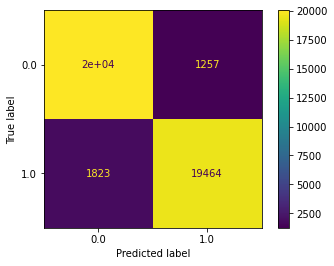



#### Metrics on Test Data ####
Accuracy is : 88.3%
Precision is : 96.2%
Recall is : 90.5%
F1 Score is : 93.3%


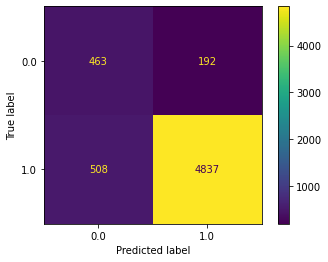

In [67]:
evaluate_model(lr, X_train, y_train, X_test, y_test)

#### Random Forest

In [68]:
rfc = RandomForestClassifier(random_state=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=100)

#### Metrics on Train Data ####
Accuracy is : 100.0%
Precision is : 100.0%
Recall is : 100.0%
F1 Score is : 100.0%


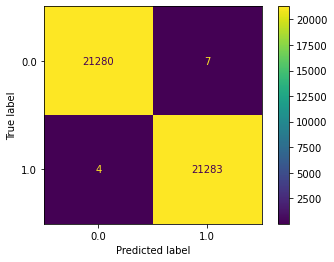



#### Metrics on Test Data ####
Accuracy is : 90.9%
Precision is : 94.2%
Recall is : 95.7%
F1 Score is : 94.9%


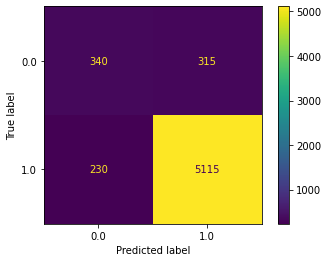

In [69]:
evaluate_model(rfc, X_train, y_train, X_test, y_test)

In [70]:
"""
# Hyperparameter tuning
parameters = {"n_estimators": range(100,500,100),
              "max_depth": range(2,7,1),
              "min_samples_split": [2, 6, 10],
              "min_samples_leaf": [1, 3, 4],
              "max_features":[i/10.0 for i in range(5,11)]}
rfc_random = RandomizedSearchCV(rfc, param_distributions = parameters,n_jobs=2,cv = 5,n_iter=20)
rfc_random.fit(X_train, y_train)
best_params_rfc = rfc_random.best_params_
print(rfc_random.best_score_)
"""

'\n# Hyperparameter tuning\nparameters = {"n_estimators": range(100,500,100),\n              "max_depth": range(2,7,1),\n              "min_samples_split": [2, 6, 10],\n              "min_samples_leaf": [1, 3, 4],\n              "max_features":[i/10.0 for i in range(5,11)]}\nrfc_random = RandomizedSearchCV(rfc, param_distributions = parameters,n_jobs=2,cv = 5,n_iter=20)\nrfc_random.fit(X_train, y_train)\nbest_params_rfc = rfc_random.best_params_\nprint(rfc_random.best_score_)\n'

In [71]:
"""
rfc_tuned = RandomForestClassifier(**best_params_rfc)
rfc_tuned.fit(X_train, y_train)
"""

'\nrfc_tuned = RandomForestClassifier(**best_params_rfc)\nrfc_tuned.fit(X_train, y_train)\n'

In [72]:
#evaluate_model(rfc_tuned, X_train, y_train, X_test, y_test)

#### XGBoost

In [73]:
xgbc = XGBClassifier(random_state=100)
xgbc.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:21:43] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Metrics on Train Data ####
Accuracy is : 94.6%
Precision is : 95.9%
Recall is : 93.1%
F1 Score is : 94.5%


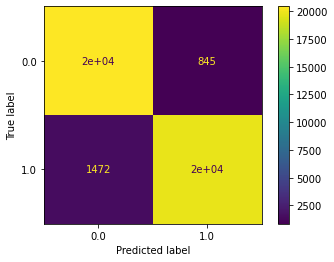



#### Metrics on Test Data ####
Accuracy is : 87.7%
Precision is : 95.4%
Recall is : 90.5%
F1 Score is : 92.9%


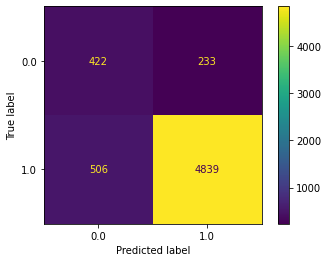

In [74]:
evaluate_model(xgbc, X_train, y_train, X_test, y_test)

In [75]:
xgbc.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 100,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [76]:
"""
# Hyperparameter tuning
parameters = {"learning_rate": [i/100.0 for i in range(2,12,2)],
              "n_estimators": range(100,800,100),
               "min_child_weight": range(1,5),
               "max_depth": range(2,7,1),
               "subsample":[i/10.0 for i in range(5,11)],
               "colsample_bytree":[i/10.0 for i in range(1,7)]}
xgbc_random = RandomizedSearchCV(xgbc, param_distributions = parameters,n_jobs=2,cv = 5,n_iter=20)
xgbc_random.fit(X_train, y_train)
best_params_xgbc = xgbc_random.best_params_
xgbc_random.best_score_
"""

'\n# Hyperparameter tuning\nparameters = {"learning_rate": [i/100.0 for i in range(2,12,2)],\n              "n_estimators": range(100,800,100),\n               "min_child_weight": range(1,5),\n               "max_depth": range(2,7,1),\n               "subsample":[i/10.0 for i in range(5,11)],\n               "colsample_bytree":[i/10.0 for i in range(1,7)]}\nxgbc_random = RandomizedSearchCV(xgbc, param_distributions = parameters,n_jobs=2,cv = 5,n_iter=20)\nxgbc_random.fit(X_train, y_train)\nbest_params_xgbc = xgbc_random.best_params_\nxgbc_random.best_score_\n'

In [77]:
"""
xgbc_tuned =XGBClassifierBClassifier(**best_params_xgbc)
xgbc_tuned.fit(X_train, y_train)
"""

'\nxgbc_tuned =XGBClassifierBClassifier(**best_params_xgbc)\nxgbc_tuned.fit(X_train, y_train)\n'

In [78]:
#evaluate_model(xgbc_tuned, X_train, y_train, X_test, y_test)

#### Naive Bayes

In [79]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

#### Metrics on Train Data ####
Accuracy is : 80.3%
Precision is : 78.8%
Recall is : 82.8%
F1 Score is : 80.8%


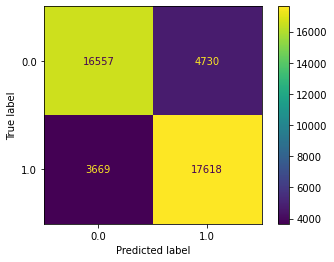



#### Metrics on Test Data ####
Accuracy is : 80.3%
Precision is : 95.2%
Recall is : 82.1%
F1 Score is : 88.1%


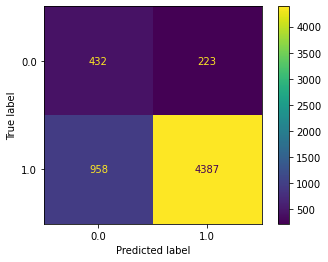

In [80]:
evaluate_model(mnb, X_train, y_train, X_test, y_test)

Random Forest Classifier gives the best metrics. Lets try the prediction on a sample text.

In [81]:
# Verify a sample positive feedback
X_sample = tfidf.transform(["Awesome product, will recommend"])
y_pred_sample = rfc.predict(X_sample)
y_pred_sample

array([1.])

In [82]:
# Verify a sample negative feedback
X_sample = tfidf.transform(["Bad product, quality is poor"])
y_pred_sample = rfc.predict(X_sample)
y_pred_sample

array([0.])

#### Save models

In [83]:
with open('models/rfc_model.pk', 'wb') as fin:
    pickle.dump(rfc, fin)

In [84]:
with open('models/tfidf_vectorizer.pk', 'wb') as fin:
    pickle.dump(tfidf, fin)

## Recommendation System

In [85]:
dfRecommendation = dfreviews[["id", "name", "reviews_rating", "reviews_username"]]
dfRecommendation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                30000 non-null  object
 1   name              30000 non-null  object
 2   reviews_rating    30000 non-null  int64 
 3   reviews_username  29937 non-null  object
dtypes: int64(1), object(3)
memory usage: 937.6+ KB


In [86]:
# Remove rows where the username id null
dfRecommendation=dfRecommendation[~dfRecommendation["reviews_username"].isnull()].reset_index()
dfRecommendation

index                    id  \
0          0  AV13O1A8GV-KLJ3akUyj   
1          1  AV14LG0R-jtxr-f38QfS   
2          2  AV14LG0R-jtxr-f38QfS   
3          3  AV16khLE-jtxr-f38VFn   
4          4  AV16khLE-jtxr-f38VFn   
...      ...                   ...   
29932  29995  AVpfW8y_LJeJML437ySW   
29933  29996  AVpfW8y_LJeJML437ySW   
29934  29997  AVpfW8y_LJeJML437ySW   
29935  29998  AVpfW8y_LJeJML437ySW   
29936  29999  AVpfW8y_LJeJML437ySW   

                                                    name  reviews_rating  \
0              Pink Friday: Roman Reloaded Re-Up (w/dvd)               5   
1             Lundberg Organic Cinnamon Toast Rice Cakes               5   
2             Lundberg Organic Cinnamon Toast Rice Cakes               5   
3                       K-Y Love Sensuality Pleasure Gel               1   
4                       K-Y Love Sensuality Pleasure Gel               1   
...                                                  ...             ...   
29932  L'or233al Paris Elvive Extraordinary Clay Reba...               5   
29933  L'or233al Paris Elvive Extraordinary Clay Reba...               5   
29934  L'or233al Paris Elvive Extraordinary Clay Reba...               5   
29935  L'or233al Paris Elvive Extraordinary Clay Reba...               5   
29936  L'or233al Paris Elvive Extraordinary Clay Reba...               5   

      reviews_username  
0               joshua  
1            dorothy w  
2            dorothy w  
3              rebecca  
4            walker557  
...                ...  
29932       laurasnchz  
29933    scarlepadilla  
29934       liviasuexo  
29935         ktreed95  
29936        kcoopxoxo  

[29937 rows x 5 columns]

In [87]:
train, test = train_test_split(dfRecommendation, train_size=0.8, random_state=100)

### User-User Based Approach

In [88]:
df_pivot = train.pivot_table(index="reviews_username", columns = "id", values = "reviews_rating")
print(df_pivot.shape)
df_pivot.head()

(20555, 256)


id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   

id                AV1YlENIglJLPUi8IHsX  AV1YmBrdGV-KLJ3adewb  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   

id                AV1YmDL9vKc47QAVgr7_  AV1Ymf_rglJLPUi8II2v  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   

id                AV1Yn94nvKc47QAVgtst  AV1YnUMYglJLPUi8IJpK  ...  \
reviews_username                                              ...   
00dog3                             NaN                   NaN  ...   
00sab00                            NaN                   NaN  ...   
01impala                           NaN                   NaN  ...   
02dakota                           NaN                   NaN  ...   
02deuce                            NaN                   NaN  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN               

In [89]:
# Normalising the rating for each user
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
print(df_subtracted.shape)
df_subtracted.head()

(20555, 256)


id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   

id                AV1YlENIglJLPUi8IHsX  AV1YmBrdGV-KLJ3adewb  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   

id                AV1YmDL9vKc47QAVgr7_  AV1Ymf_rglJLPUi8II2v  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   

id                AV1Yn94nvKc47QAVgtst  AV1YnUMYglJLPUi8IJpK  ...  \
reviews_username                                              ...   
00dog3                             NaN                   NaN  ...   
00sab00                            NaN                   NaN  ...   
01impala                           NaN                   NaN  ...   
02dakota                           NaN                   NaN  ...   
02deuce                            NaN                   NaN  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
00dog3                             NaN                   NaN   
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN               

In [90]:
# Creating dummy train and test to be used for prediction of the products not rated by the user
dummy_train = train.copy()
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(index="reviews_username", columns = "id", values = "reviews_rating").fillna(1)
dummy_train.head()

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
02deuce                            1.0                   1.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
02deuce                            1.0                   1.0   

id                AV1YlENIglJLPUi8IHsX  AV1YmBrdGV-KLJ3adewb  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
02deuce                            1.0                   1.0   

id                AV1YmDL9vKc47QAVgr7_  AV1Ymf_rglJLPUi8II2v  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
02deuce                            1.0                   1.0   

id                AV1Yn94nvKc47QAVgtst  AV1YnUMYglJLPUi8IJpK  ...  \
reviews_username                                              ...   
00dog3                             1.0                   1.0  ...   
00sab00                            1.0                   1.0  ...   
01impala                           1.0                   1.0  ...   
02dakota                           1.0                   1.0  ...   
02deuce                            1.0                   1.0  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
02deuce                            1.0                   1.0   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
02deuce                            1.0                   1.0   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   
02deuce                            1.0                   1.0   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
00dog3                             1.0                   1.0   
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0               

#### Cosine Similarity

In [91]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Prediction

In [92]:
# Prediction for the users which are positively related with other users
user_correlation[user_correlation<0]=0
print(user_correlation.shape)
user_correlation

(20555, 20555)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [93]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
print(user_predicted_ratings.shape)
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

(20555, 256)


id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00dog3                             0.0              0.000000   
00sab00                            2.5              5.828828   
01impala                           0.0              0.000000   
02dakota                           0.0              0.000000   
02deuce                            0.0              0.000000   

id                AV1YlENIglJLPUi8IHsX  AV1YmBrdGV-KLJ3adewb  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AV1YmDL9vKc47QAVgr7_  AV1Ymf_rglJLPUi8II2v  \
reviews_username                                               
00dog3                         0.00000                   0.0   
00sab00                        0.67658                   0.0   
01impala                       0.00000                   0.0   
02dakota                       0.00000                   0.0   
02deuce                        0.00000                   0.0   

id                AV1Yn94nvKc47QAVgtst  AV1YnUMYglJLPUi8IJpK  ...  \
reviews_username                                              ...   
00dog3                        0.000000                   0.0  ...   
00sab00                       2.005644                   0.0  ...   
01impala                      0.000000                   0.0  ...   
02dakota                      0.000000                   0.0  ...   
02deuce                       0.000000                   0.0  ...   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AVpfs0tUilAPnD_xgqN2  AVpfsQoeilAPnD_xgfx5  \
reviews_username                                               
00dog3                        0.000000                   0.0   
00sab00                       2.592998                   0.0   
01impala                      0.000000                   0.0   
02dakota                      0.000000                   0.0   
02deuce                       0.000000                   0.0   

id                AVpfshNsLJeJML43CB8q  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
00dog3                             0.0                   0.0   
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   

id                AVpftikC1cnluZ0-p31V  AVpftymALJeJML43CZ6y  \
reviews_username                                               
00dog3                        0.000000                   0.0   
00sab00                       2.808965                   0.0   
01impala                      0.000000                   0.0   
02dakota                      0.000000               

In [94]:
user_final_rating.sum(axis=1).sort_values(ascending=False)

reviews_username
marty                 448.061447
nana                  432.416563
fred23                429.388859
tyler                 429.388859
joey                  418.421415
                         ...    
georgemag               0.000000
georgek16               0.000000
georgeclooneystwin      0.000000
george67                0.000000
zzz1127                 0.000000
Length: 20555, dtype: float64

#### Top 20 recommendations for a user

In [95]:
# Take the user ID as input.
user_input = input("Enter your user name ")
print(user_input)

Enter your user name marty
marty


In [96]:
rec = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
rec

id
AVpf0eb2LJeJML43EVSt    59.685846
AVpe41TqilAPnD_xQH3d    52.360949
AVpfRTh1ilAPnD_xYic2    36.749544
AVpe59io1cnluZ0-ZgDU    36.013734
AVpf2tw1ilAPnD_xjflC    27.846504
AVpfJP1C1cnluZ0-e3Xy    20.352188
AVpf5olc1cnluZ0-tPrO    18.219302
AVpf0thK1cnluZ0-r8vR    13.254589
AVpf385g1cnluZ0-s0_t    12.182784
AVpfD9xTLJeJML431ig2    11.781451
AVpfBrUZilAPnD_xTUly     8.742765
AVpfM_ytilAPnD_xXIJb     8.320636
AVpfR5m0LJeJML436K3W     8.168232
AVpe31o71cnluZ0-YrSD     7.419878
AVpfPnrU1cnluZ0-g9rL     6.521668
AVpfRoqcLJeJML436FqG     5.949215
AVpfoSS51cnluZ0-oVH9     5.907242
AVpfMpZ51cnluZ0-f_L9     5.472123
AVpfQtEm1cnluZ0-hUpe     5.433570
AVpfm8yiLJeJML43AYyu     5.097109
Name: marty, dtype: float64

In [97]:
#display the top 20 product id, name and similarity_score
dfrec=pd.DataFrame(rec).reset_index()
dfrec.columns=['id','similarity_score']
#final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
#final_recommendations.reset_index(drop=True)
pd.merge(dfrec, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

id                                               name  \
0     AVpf0eb2LJeJML43EVSt     The Resident Evil Collection 5 Discs (blu-Ray)   
693   AVpe41TqilAPnD_xQH3d       Mike Dave Need Wedding Dates (dvd + Digital)   
1305  AVpfRTh1ilAPnD_xYic2  Planes: Fire Rescue (2 Discs) (includes Digita...   
2193  AVpe59io1cnluZ0-ZgDU  My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...   
2717  AVpf2tw1ilAPnD_xjflC                   Red (special Edition) (dvdvideo)   
3266  AVpfJP1C1cnluZ0-e3Xy               Clorox Disinfecting Bathroom Cleaner   
4920  AVpf5olc1cnluZ0-tPrO          Chester's Cheese Flavored Puffcorn Snacks   
5070  AVpf0thK1cnluZ0-r8vR                100:Complete First Season (blu-Ray)   
5175  AVpf385g1cnluZ0-s0_t                             Hormel Chili, No Beans   
5330  AVpfD9xTLJeJML431ig2                 There's Something About Mary (dvd)   
5441  AVpfBrUZilAPnD_xTUly  Coty Airspun Face Powder, Translucent Extra Co...   
5565  AVpfM_ytilAPnD_xXIJb                  Tostitos Bite Size Tortilla Chips   
5769  AVpfR5m0LJeJML436K3W                     Jason Aldean - They Don't Know   
5927  AVpe31o71cnluZ0-YrSD  Dark Shadows (includes Digital Copy) (ultravio...   
6129  AVpfPnrU1cnluZ0-g9rL  Stargate (ws) (ultimate Edition) (director's C...   
6287  AVpfRoqcLJeJML436FqG                     Vicks Vaporub, Regular, 3.53oz   
6359  AVpfoSS51cnluZ0-oVH9  Cheetos Crunchy Flamin' Hot Cheese Flavored Sn...   
6404  AVpfMpZ51cnluZ0-f_L9  Chips Ahoy! Original Chocolate Chip - Cookies ...   
6457  AVpfQtEm1cnluZ0-hUpe          Jolly Time Select Premium Yellow Pop Corn   
6481  AVpfm8yiLJeJML43AYyu          Nexxus Exxtra Gel Style Creation Sculptor   

      similarity_score  
0            59.685846  
693          52.360949  
1305         36.749544  
2193         36.013734  
2717         27.846504  
3266         20.352188  
4920         18.219302  
5070         13.254589  
5175         12.182784  
5330         11.781451  
5441          8.742765  
5565          8.320636  
5769          8.168232  
5927          7.419878  
6129          6.521668  
6287          5.949215  
6359          5.907242  
6404          5.472123  
6457          5.433570  
6481          5.097109

#### Evaluation

In [98]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1513, 5)

In [99]:
common.head()

index                    id  \
18940  18987  AVpfJP1C1cnluZ0-e3Xy   
26843  26906  AVpfR5m0LJeJML436K3W   
29455  29518  AVpfW8y_LJeJML437ySW   
26953  27016  AVpfR5m0LJeJML436K3W   
20118  20165  AVpfJP1C1cnluZ0-e3Xy   

                                                    name  reviews_rating  \
18940               Clorox Disinfecting Bathroom Cleaner               5   
26843                     Jason Aldean - They Don't Know               5   
29455  L'or233al Paris Elvive Extraordinary Clay Reba...               4   
26953                     Jason Aldean - They Don't Know               5   
20118               Clorox Disinfecting Bathroom Cleaner               5   

      reviews_username  
18940           angie2  
26843            happy  
29455         ktpurdie  
26953          brandon  
20118         ash82085

In [100]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index="reviews_username", columns = "id", values = "reviews_rating")
common_user_based_matrix.head()

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
37f5p                              NaN                   NaN   

id                AV1YlENIglJLPUi8IHsX  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
37f5p                              NaN                   NaN   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
37f5p                              NaN                   NaN   

id                AV1YneDPglJLPUi8IJyQ  AV1YqAaMGV-KLJ3adiDj  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
37f5p                              NaN                   NaN   

id                AV1Ys0kTvKc47QAVgx1C  AV1YtGjdglJLPUi8IOfJ  ...  \
reviews_username                                              ...   
1234                               NaN                   NaN  ...   
1234567                            NaN                   NaN  ...   
1943                               NaN                   NaN  ...   
1witch                             NaN                   NaN  ...   
37f5p                              NaN                   NaN  ...   

id                AVpfm8yiLJeJML43AYyu  AVpfmjXGLJeJML43AQ5_  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
37f5p                              NaN                   NaN   

id                AVpfoSS51cnluZ0-oVH9  AVpfov9TLJeJML43A7B0  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
37f5p                              NaN                   NaN   

id                AVpfpM2yilAPnD_xfmDG  AVpfr5cb1cnluZ0-pZFp  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN                   NaN   
37f5p                              NaN                   NaN   

id                AVpfrFDZLJeJML43Bmv0  AVpftikC1cnluZ0-p31V  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   
1943                               NaN                   NaN   
1witch                             NaN               

In [101]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

   20545  20546  20547  20548  20549  20550  20551  20552  20553  20554  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 20555 columns]

In [102]:
user_correlation_df["reviews_username"] = df_pivot.index
user_correlation_df.set_index("reviews_username",inplace=True)
user_correlation_df.head()

0      1      2      3      4      5      6      7      \
reviews_username                                                           
00dog3              0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
00sab00             0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
01impala            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
02dakota            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
02deuce             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                  8      9      ...  20545  20546  20547  20548  20549  20550  \
reviews_username                ...                                             
00dog3              0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
00sab00             0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
01impala            0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
02dakota            0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
02deuce             0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   

                  20551  20552  20553  20554  
reviews_username                              
00dog3              0.0    0.0    0.0    0.0  
00sab00             0.0    0.0    0.0    0.0  
01impala            0.0    0.0    0.0    0.0  
02dakota            0.0    0.0    0.0    0.0  
02deuce             0.0    0.0    0.0    0.0  

[5 rows x 20555 columns]

In [103]:
list_name = common.reviews_username.tolist()
user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1.shape

(1320, 20555)

In [104]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 2.62373781, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [105]:
dummy_test = common.copy()
dummy_test["reviews_rating"] = dummy_test["reviews_rating"].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index="reviews_username", columns = "id", values = "reviews_rating").fillna(0)
dummy_test.shape

(1320, 115)

In [106]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head()

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
37f5p                              0.0                   0.0   

id                AV1YlENIglJLPUi8IHsX  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
37f5p                              0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
37f5p                              0.0                   0.0   

id                AV1YneDPglJLPUi8IJyQ  AV1YqAaMGV-KLJ3adiDj  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
37f5p                              0.0                   0.0   

id                AV1Ys0kTvKc47QAVgx1C  AV1YtGjdglJLPUi8IOfJ  ...  \
reviews_username                                              ...   
1234                               0.0                   0.0  ...   
1234567                            0.0                   0.0  ...   
1943                               0.0                   0.0  ...   
1witch                             0.0                   0.0  ...   
37f5p                              0.0                   0.0  ...   

id                AVpfm8yiLJeJML43AYyu  AVpfmjXGLJeJML43AQ5_  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
37f5p                              0.0                   0.0   

id                AVpfoSS51cnluZ0-oVH9  AVpfov9TLJeJML43A7B0  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
37f5p                              0.0                   0.0   

id                AVpfpM2yilAPnD_xfmDG  AVpfr5cb1cnluZ0-pZFp  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0                   0.0   
37f5p                              0.0                   0.0   

id                AVpfrFDZLJeJML43Bmv0  AVpftikC1cnluZ0-p31V  \
reviews_username                                               
1234                               0.0                   0.0   
1234567                            0.0                   0.0   
1943                               0.0                   0.0   
1witch                             0.0               

In [107]:
#calculate RMSE
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [108]:
common_ = common.pivot_table(index="reviews_username", columns = "id", values = "reviews_rating")

In [117]:
y

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [115]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_.values - y )**2))/total_non_nan)**0.5
print(rmse)

nan


### Item-Item Based Approach

In [ ]:
df_pivot = train.pivot_table(index="reviews_username", columns = "id", values = "reviews_rating").T
df_pivot.head()

In [ ]:
# Normalising the product rating for each product for using the Adujsted Cosine
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

In [ ]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

In [ ]:
item_correlation[item_correlation<0]=0
item_correlation

#### Prediction

In [ ]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
print(item_predicted_ratings.shape)
item_predicted_ratings

In [ ]:
# Filtering the rating only for the product not rated by the user for recommendation
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

In [ ]:
# Take the user ID as input
user_input = input("Enter your user name ")
print(user_input)

In [ ]:
# Recommending the Top 5 products to the user.
rec = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
rec

In [ ]:
#display the top 20 product id, name and similarity_score
dfrec=pd.DataFrame(rec).reset_index()
dfrec.columns=['id','similarity_score']
#final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
#final_recommendations.reset_index(drop=True)
pd.merge(dfrec, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

#### Evaluation

In [ ]:
common =  test[test.id.isin(train.id)]
print(common.shape)
common.head()

In [ ]:
common_item_based_matrix = common.pivot_table(index="id", columns="reviews_username", values="reviews_rating")
common_item_based_matrix

In [ ]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head()

In [ ]:
item_correlation_df["id"] = df_subtracted.index
item_correlation_df.set_index("id",inplace=True)
item_correlation_df.head()

In [ ]:
list_name = common.id.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3.head()

In [ ]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

In [ ]:
# make prediction on the products rated by the user.
dummy_test = common.copy()
dummy_test["reviews_rating"] = dummy_test["reviews_rating"].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index="id", columns="reviews_username", values="reviews_rating").fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [ ]:
common_ = common.pivot_table(index="id", columns="reviews_username", values="reviews_rating")

In [ ]:
# calculate rmse
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

User based recommendation model seems to be better as it has a lower RMSE value

In [ ]:
# Save the user based correlation matrix 
with open('models/user_final_rating.pk', 'wb') as fin:
    pickle.dump(user_final_rating, fin)

### Improving the recommendations using the sentiment analysis model

In [ ]:
dfreviews.head()

In [ ]:
username=user_input
username

In [ ]:
def get_top5(username):
    if username in user_final_rating.index:
        recommendations=list(user_final_rating.loc[username].sort_values(ascending=False)[0:20].index)
        dfTemp=dfSentiment[dfSentiment.id.isin(recommendations)]
        X=tfidf.transform(dfTemp["reviews_processed"])
        dfTemp['user_sentiment_pred']=rfc.predict(X)
        dfTempG=dfTemp.groupby(['id','name']).agg({'user_sentiment_pred':['count','sum']})
        dfTempG.columns=['total_count','pos_count']
        dfTempG.reset_index(inplace=True)
        dfTempG['pos_per']=dfTempG['pos_count']/dfTempG['total_count']
        print(dfTempG.sort_values('pos_per',ascending=False)[:5])
        top5_list=dfTempG.sort_values('pos_per',ascending=False)[:5].name.tolist()
        return top5_list
    else:
        print('User not found!!!')

In [ ]:
get_top5(username)

In [ ]:
get_top5('deepak')